#### Importing the train.csv file

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
import contractions
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from collections import Counter

In [2]:

pd.set_option("display.max_colwidth", 200)

In [3]:
# train_data = pd.read_csv('Data/cleaned_data_150k.csv', encoding='latin1')
train_data = pd.read_csv('Data/cleaned_data_150k.csv')

In [4]:
train_data.head()

,text,target
0,An image forming apparatus of the present invention includes: a replaceable part used for image formation; an output unit configured to output information indicating that a usage amount of the rep...,0
1,"However, in the conventional aerial vehicle described above, the balloon has a problem that it is difficult to control the direction of movement of the balloon to be greatly affected by the wind b...",2
2,The first aspect of a method for recovering a metal from a target according to the present invention is a method for recovering a metal from a target that consists essentially of a CoCrPt-based me...,1
3,"First Aspect of Invention', 'The present invention was developed in view of the aforementioned problem. In order to solve the aforementioned problem, the first aspect of the invention provides a h...",0
4,"As described above, according to the cap, the cap mold, and the securing structure part using the cap of the present invention, the structures thereof are simple and have improved productivity and...",1


In [5]:
# train_data.drop(['textID', 'Time of Tweet', 'Age of User', 'Country', 'Population -2020', 'Land Area (Kmï¿½)', 'Density (P/Kmï¿½)'], axis=1, inplace=True)
# train_data['sentiment'] = train_data['sentiment'].replace({'positive': 1, 'negative': 2, 'neutral': 0})

In [6]:
train_data.head()

,text,target
0,An image forming apparatus of the present invention includes: a replaceable part used for image formation; an output unit configured to output information indicating that a usage amount of the rep...,0
1,"However, in the conventional aerial vehicle described above, the balloon has a problem that it is difficult to control the direction of movement of the balloon to be greatly affected by the wind b...",2
2,The first aspect of a method for recovering a metal from a target according to the present invention is a method for recovering a metal from a target that consists essentially of a CoCrPt-based me...,1
3,"First Aspect of Invention', 'The present invention was developed in view of the aforementioned problem. In order to solve the aforementioned problem, the first aspect of the invention provides a h...",0
4,"As described above, according to the cap, the cap mold, and the securing structure part using the cap of the present invention, the structures thereof are simple and have improved productivity and...",1


#### Working with Label

In [7]:
# train_data['sentiment'].value_counts()
train_data['target'].value_counts()

target
0    50000
2    50000
1    50000
Name: count, dtype: int64

<Axes: xlabel='target'>

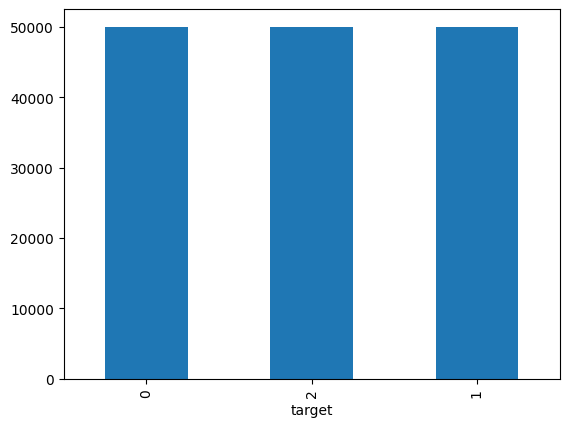

In [8]:
# train_data['sentiment'].value_counts().plot(kind='bar')
train_data['target'].value_counts().plot(kind='bar')

Text(0.5, 1.0, 'label distribution')

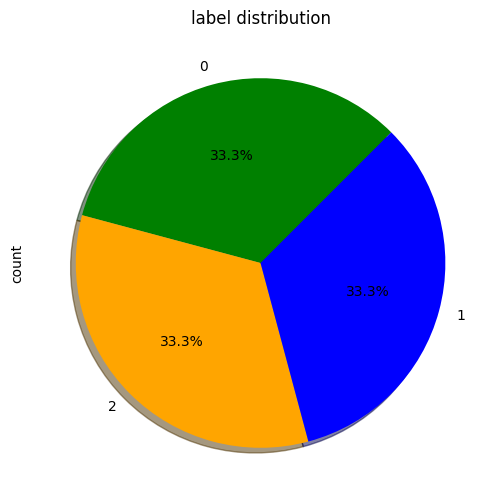

In [9]:
plt.figure(figsize=(10,6))
colors = ['green', 'orange', 'blue']
train_data['target'].value_counts().plot(kind='pie', autopct='%.1f%%', shadow=True, colors = colors, startangle=45)
plt.title('label distribution')

#### Cleaning the Text

In [10]:
# Combining nltk stopwords and sklearn stopwrods. 
nltk_stopwords = set(stopwords.words('english'))
nltk_stopwords.remove('not')

import sklearn
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
sklearn_stopwords = set(ENGLISH_STOP_WORDS)

# joining both the stopwords 
all_stopwords = nltk_stopwords.union(sklearn_stopwords)

all_stopwords_list = list(all_stopwords)

In [11]:
train_data['text'][27477]

"However, the usual terminal fitting 501 requires a process for applying the corrosion preventing agent after the terminal is manufactured, so that an operating process is increased. The corrosion preventing agent as an insulator needs to be masked so that the corrosion preventing agent is not spread to the core wire barrel piece 511 or a contact part. Thus, an operating process is further increased. Further, the corrosion preventing agent is not applied to the core wire barrel piece 511. Thus, corrosion due to an entry of water from an exposed part of a boundary of the core wire barrel piece 511 and the core wire 507 cannot be prevented.', 'The present invention is devised by considering the circumstances and it is an object of the present invention to provide a terminal which prevents a contact corrosion of dissimilar metals between a core wire and a terminal made of the dissimilar metals and simplifies an operating process more than an application of an insulator after a production.

In [12]:
emoji_pattern = re.compile('(?::|;|=)(?:-)?(?:\)|\(|D|P)')
# nltk.download('punkt')
# nltk.download('wordnet')
def cleaning_the_data(text):
    if not isinstance(text, str):
        text = str(text)
        
    new_text = re.sub(r"'s\b'",' is', text)
    new_text = re.sub(r"#", " ", new_text)
    new_text = re.sub(r"@[A-Za-z0-9]+", " ", new_text)
    new_text = re.sub(r"http\s+", " ", new_text)
    new_text = contractions.fix(new_text)
    new_text = re.sub(r"[^a-zA-Z]", " ", new_text)
    new_text = re.sub(emoji_pattern, '', new_text)
    new_text = new_text.lower().strip()

    new_text = re.sub(r"\b(?:not|no|never|none|nobody|nowhere|nothing)\b[\w\s]+[^\w\s]", "not_negative", new_text)
    return new_text

def normalize_text(text):
    cleaned_text = cleaning_the_data(text)
    # Tokenize the text
    tokens = word_tokenize(cleaned_text)
    
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word, pos='a') for word in tokens if len(word) > 2]
    
    # Remove stopwords
    filtered_tokens = [word for word in lemmatized_tokens if word.lower() not in all_stopwords_list]
    
    # Join tokens back into a single string
    normalized_text = ' '.join(filtered_tokens)
    return normalized_text

train_data['normalized_text'] = train_data['text'].apply(normalize_text)

In [13]:
train_data['normalized_text'][27477]

'usual terminal fitting requires process applying corrosion preventing agent terminal manufactured operating process increased corrosion preventing agent insulator needs masked corrosion preventing agent spread core wire barrel piece contact operating process increased corrosion preventing agent applied core wire barrel piece corrosion entry water exposed boundary core wire barrel piece core wire prevented present invention devised considering circumstances object present invention provide terminal prevents contact corrosion dissimilar metals core wire terminal dissimilar metals simplifies operating process application insulator production'

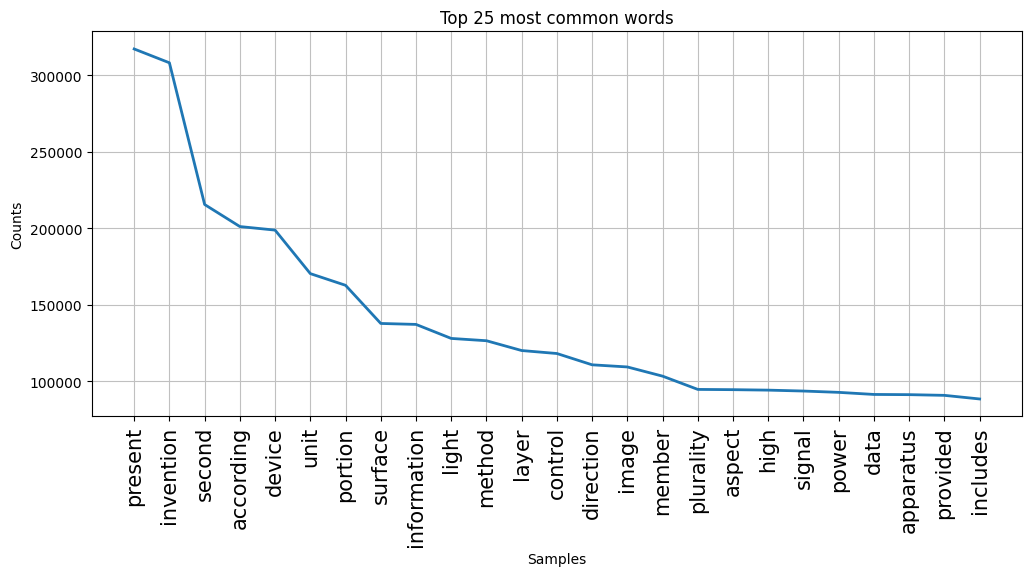

In [14]:
all_words = []
for t in train_data['normalized_text']:
    all_words.extend(t.split())

freq_dist = nltk.FreqDist(all_words)

plt.figure(figsize=(12,5))
plt.title('Top 25 most common words')
plt.xticks(fontsize=15)

freq_dist.plot(25, cumulative=False)

plt.show()

#### Visualizing Negative and Positive Words

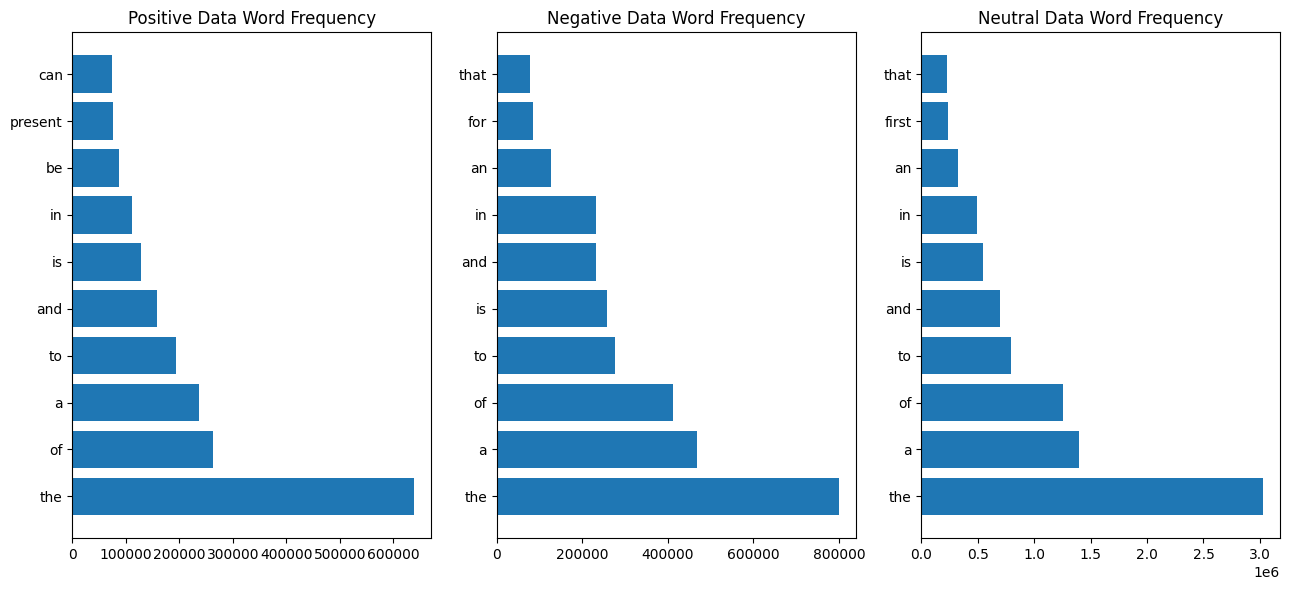

In [15]:
neutraldata = train_data[train_data['target'] == 0]['text'].astype(str)

positivedata = train_data[train_data['target'] == 1]['text'].astype(str)

negdata = train_data[train_data['target'] == 2]['text'].astype(str)

# Positive data
positivedata_words = ' '.join(positivedata).split()
positivedata_words_count = Counter(positivedata_words)
positivedata_common_words = positivedata_words_count.most_common(10)  # Display top 10 common words 

# Negative data
negdata_words = ' '.join(negdata).split()
negdata_words_count = Counter(negdata_words)
negdata_common_words = negdata_words_count.most_common(10)  # Display top 10 common words 

# Neutral data
neutraldata_words = ' '.join(neutraldata).split()
neutraldata_words_count = Counter(neutraldata_words)
neutraldata_common_words = neutraldata_words_count.most_common(10)  # Display top 10 common words 

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(13, 6))

# Positive data word frequency
axes[0].barh(range(len(positivedata_common_words)), [count for _, count in positivedata_common_words], align='center')
axes[0].set_yticks(range(len(positivedata_common_words)))
axes[0].set_yticklabels([word for word, _ in positivedata_common_words])
axes[0].set_title('Positive Data Word Frequency')

# Negative data word frequency
axes[1].barh(range(len(negdata_common_words)), [count for _, count in negdata_common_words], align='center')
axes[1].set_yticks(range(len(negdata_common_words)))
axes[1].set_yticklabels([word for word, _ in negdata_common_words])
axes[1].set_title('Negative Data Word Frequency')

# Neutral data word frequency
axes[-1].barh(range(len(neutraldata_common_words)), [count for _, count in neutraldata_common_words], align='center')
axes[-1].set_yticks(range(len(neutraldata_common_words)))
axes[-1].set_yticklabels([word for word, _ in neutraldata_common_words])
axes[-1].set_title('Neutral Data Word Frequency')

plt.tight_layout()
plt.show()

### Bag of words model (Feature Extraction)
    1. Countvectorizer
    2. TF-IDF Vectorizer

In [16]:
train_data.shape

(150000, 3)

### Model building

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer

In [18]:

tfidf = TfidfVectorizer(strip_accents=None, lowercase=False, preprocessor=None, tokenizer=None, use_idf=True, norm='l2', smooth_idf=True)
y = train_data['target'].values
x = tfidf.fit_transform(train_data['normalized_text'])
X_train,X_test,y_train,y_test=train_test_split(x,y,random_state=1,test_size=0.4,shuffle=False)

In [19]:
clf = LogisticRegressionCV(cv=6, scoring='accuracy', random_state=0, n_jobs=-1, verbose=3, max_iter=500).fit(x, y)
y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed: 14.2min remaining: 14.2min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed: 14.5min finished


Accuracy: 0.9588


In [20]:
import pickle

# Saving the model
filename = 'clf1.pkl'
pickle.dump(clf, open(filename, 'wb'))

# Saving the vectorizer
filename = 'tfidf1.pkl'
pickle.dump(tfidf, open(filename, 'wb'))

# train_data.to_pickle('train_data.pkl')

#### Prediction

In [21]:
def prediction(comment):
    preprocess_comment = normalize_text(comment)
    comment_list = [preprocess_comment]
    comment_vector = tfidf.transform(comment_list)
    prediction = clf.predict(comment_vector)
    if prediction == 0:
        return 'Neutral'
    elif prediction == 1:
        return 'Positive'
    else:
        return 'Negative'

comment = "not like the movie at all it was boring and not interesting"      
print(prediction(comment))

Negative
